# Image Denoising

Suppose you are given a noisy image $f(x,y)$ and wish to find obtain a denoised image $u(x,y)$ that is as similar to the original image $f$. Mathematically, what we aim to find is 
$$\min_{
    \substack{u(x,y)}
} E(u(x,y)) = \iint_{\Omega} |\nabla u(x,y)| + \frac{\lambda}{2} \|u(x,y) - f(x,y)\|^2_2 \,dxdy$$
We want to find a new image $u$ that is similar to $f$ only with a small gradient (less rapid changes in adjacent pixel values, i.e. less noise). $\lambda$ is a user-defined parameter that decides the importance of each term.

To minimize $E$, we take its derivative and set it equal to $0$. However, because $E$ is a functional, we must use calculus of varitions to differentiate it. Doing so, we find that a stationary point for $E$ must satisfy the Euler-Lagrange Equation
$$\frac{\partial F}{\partial u} - \frac{\partial}{\partial x}\left(\frac{\partial F}{\partial u_x}\right) - \frac{\partial}{\partial y}\left(\frac{\partial F}{\partial u_y}\right) = 0$$
where $F = |\nabla u(x,y)| + \frac{\lambda}{2} \|u(x,y) - f(x,y)\|^2_2$.

Differentiating,
$$\frac{\partial F}{\partial u} = \lambda(u - f), \quad \frac{\partial F}{\partial u_x} = \frac{u_x}{\sqrt{u_x^2 + u_y^2}}, \quad \frac{\partial F}{\partial u_y} = \frac{u_y}{\sqrt{u_x^2 + u_y^2}}$$
and substituting in, we get
$$\begin{align*}
&\lambda(u - f) - \frac{\partial}{\partial x}\left(\frac{u_x}{\sqrt{u_x^2 + u_y^2}}\right) - \frac{\partial}{\partial y}\left(\frac{u_y}{\sqrt{u_x^2 + u_y^2}}\right) = 0, \\
\iff &\lambda(u - f) - \nabla \cdot \left(\frac{\nabla u}{|\nabla u|}\right) = 0
\end{align*}$$

This is a very diffcult PDE to solve analytically, so we will solve it numericlly using a finite discretization scheme combined with gradient descent.

For a grid spacing h = 1, the forward differences approximate the gradient:
$$
\begin{align*}
(u_x)_{i,j}^+ &= \frac{u_{i+1,j} - u_{i,j}}{h} \\
(u_y)_{i,j}^+ &= \frac{u_{i,j+1} - u_{i,j}}{h}
\end{align*}
$$

Similarly, the backward differences are:
$$
\begin{align*}
(u_x)_{i,j}^- &= \frac{u_{i,j} - u_{i-1,j}}{h} \\
(u_y)_{i,j}^- &= \frac{u_{i,j} - u_{i,j-1}}{h}
\end{align*}
$$

To avoid numerical instability when dividing by the gradient, we let $\nabla u = \nabla u + \epsilon$ and get that
$$|\nabla u|_{\epsilon} = \sqrt{u_x^2 + u_y^2 + \epsilon}$$

Discretizing the divergence term using central differences, we get that
$$
\text{div}\left(\frac{\nabla u}{|\nabla u|}\right) \approx \frac{1}{h}\left(\frac{(u_x)^+}{|\nabla u|_{\epsilon}^+} - \frac{(u_x)-}{|\nabla u|_{\epsilon}^-}\right) + \frac{1}{h}\left(\frac{(u_y)^+}{|\nabla u|_{\epsilon}^+} - \frac{(u_y)^-}{|\nabla u|_{\epsilon}^-}\right)
$$

The gradient descent update is then
$$u^{n+1} = u^n - \eta \left[\lambda(u^n - f) - \text{div}\left(\frac{\nabla u^n}{|\nabla u^n|}\right)\right]$$
where $\eta$ is the step size.

Note: In the implementation below, $h$ is assumed to be $1$ as most image formats store pixels as equally spaced gridpoints.

In [21]:
import numpy as np
import matplotlib.pyplot as plt
from skimage import io
from skimage.util import random_noise

In [22]:
def add_noise(image, noise_type='gaussian', var=0.01):
    """Add noise to an input image.

    Parameters
    ----------
    image : ndarray
        Input image as numpy array of shape (H,W) with values in [0,1]
    noise_type : str, optional
        Type of noise to add, by default 'gaussian'
        Options: ['gaussian', 'salt', 'pepper', 's&p', 'speckle', 'poisson']
        Note: For 'salt', 'pepper', and 's&p', var parameter represents amount of noise
    var : float, optional
        Variance/intensity of noise, must be in [0,1], by default 0.01
        For Gaussian/Speckle: represents variance of noise
        For Salt/Pepper: represents proportion of pixels to corrupt

    Returns
    -------
    ndarray
        Noisy image as numpy array of same shape as input with values in [0,1]

    Examples
    --------
    >>> img = np.random.random((100, 100))
    >>> noisy_img = add_noise(img, noise_type='gaussian', var=0.1)
    """
    # For salt, pepper, and s&p noise, 'var' represents 'amount'
    if noise_type in ['salt', 'pepper', 's&p']:
        return random_noise(image, mode=noise_type, amount=var)
    # For other noise types, use 'var'
    else:
        return random_noise(image, mode=noise_type, var=var)

In [23]:
def denoise_image(f, lambda_val=1.0, epsilon=1e-6, num_iters=100, eta=0.1):
    """Perform TV-L2 denoising using gradient descent.

    Uses the ROF (Rudin-Osher-Fatemi) model to remove noise while preserving edges.

    Parameters
    ----------
    f : ndarray
        Input noisy image as numpy array of shape (H,W) with values in [0,1]
    lambda_val : float, optional
        Regularization parameter (higher = more detail preserved), by default 1.0
        Must be positive
    epsilon : float, optional
        Small constant to avoid division by zero, by default 1e-6
        Must be positive
    num_iters : int, optional
        Number of gradient descent iterations, by default 100
        Must be positive
    dt : float, optional
        Time step for gradient descent, by default 0.1
        Must be positive

    Returns
    -------
    ndarray
        Denoised image as numpy array of same shape as input with values in [0,1]

    Examples
    --------
    >>> noisy_img = np.random.random((100, 100))
    >>> clean_img = denoise_image(noisy_img, lambda_val=1.0, num_iters=50)
    """
    u = f.copy()
    h = 1.0
    
    for _ in range(num_iters):
        # Forward differences
        ux_f = np.zeros_like(u)
        uy_f = np.zeros_like(u)
        ux_f[:-1,:] = (u[1:,:] - u[:-1,:]) / h
        uy_f[:,:-1] = (u[:,1:] - u[:,:-1]) / h
        
        # Backward differences
        ux_b = np.zeros_like(u)
        uy_b = np.zeros_like(u)
        ux_b[1:,:] = (u[1:,:] - u[:-1,:]) / h
        uy_b[:,1:] = (u[:,1:] - u[:,:-1]) / h
        
        # Compute gradients magnitude
        grad_mag_f = np.sqrt(ux_f**2 + uy_f**2 + epsilon)
        grad_mag_b = np.sqrt(ux_b**2 + uy_b**2 + epsilon)
        
        # Compute divergence term
        div_term = (
            (1/h) * (ux_f/grad_mag_f - ux_b/grad_mag_b) +
            (1/h) * (uy_f/grad_mag_f - uy_b/grad_mag_b)
        )
        
        # Update step
        u -= eta * (lambda_val * (u - f) - div_term)
        
    return u



In [24]:
def process_and_display(image_path, apply_noise=False, noise_type='gaussian', noise_var=0.01, lambda_val=1.0, num_iters=100, eta=0.1):
    """Load, add noise to, denoise, and display an image.

    Parameters
    ----------
    image_path : str
        Path to the input image file
    apply_noise : bool, optional
        Whether to add noise to the image, by default False
    noise_type : str, optional
        Type of noise to add if apply_noise is True, by default 'gaussian'
        Options: ['gaussian', 'salt', 'pepper', 's&p', 'speckle', 'poisson']
    noise_var : float, optional
        Variance of noise to add if apply_noise is True, must be in [0,1], by default 0.01
    lambda_val : float, optional
        Regularization parameter for denoising, must be positive, by default 1.0
    num_iters : int, optional
        Number of denoising iterations, must be positive, by default 100

    Returns
    -------
    tuple
        (original, noisy, denoised) where each is a numpy array of shape (H,W)
        with values in [0,1]

    Notes
    -----
    Also displays the three images (original, noisy, denoised) using matplotlib.

    Examples
    --------
    >>> original, noisy, denoised = process_and_display('image.jpg', add_noise=True, noise_type='pepper', noise_var=0.1)
    """
    # Read and normalize image
    image = io.imread(image_path)
    if image.ndim == 3:
        image = np.mean(image, axis=2)  # Convert to grayscale
    image = image / 255.0  # Normalize to [0,1]
    
    # Add noise if requested
    noisy = image
    if apply_noise:
        noisy = add_noise(image, noise_type=noise_type, var=noise_var)
    
    # Denoise
    denoised = denoise_image(noisy, lambda_val=lambda_val, num_iters=num_iters, eta=eta)
    
    # Display results
    fig, axes = plt.subplots(1, 3, figsize=(15, 5))
    
    axes[0].imshow(image, cmap='gray')
    axes[0].set_title('Original')
    axes[0].axis('off')
    
    axes[1].imshow(noisy, cmap='gray')
    axes[1].set_title('Noisy')
    axes[1].axis('off')
    
    axes[2].imshow(denoised, cmap='gray')
    axes[2].set_title('Denoised')
    axes[2].axis('off')
    
    plt.tight_layout()
    plt.show()
    
    return image, noisy, denoised

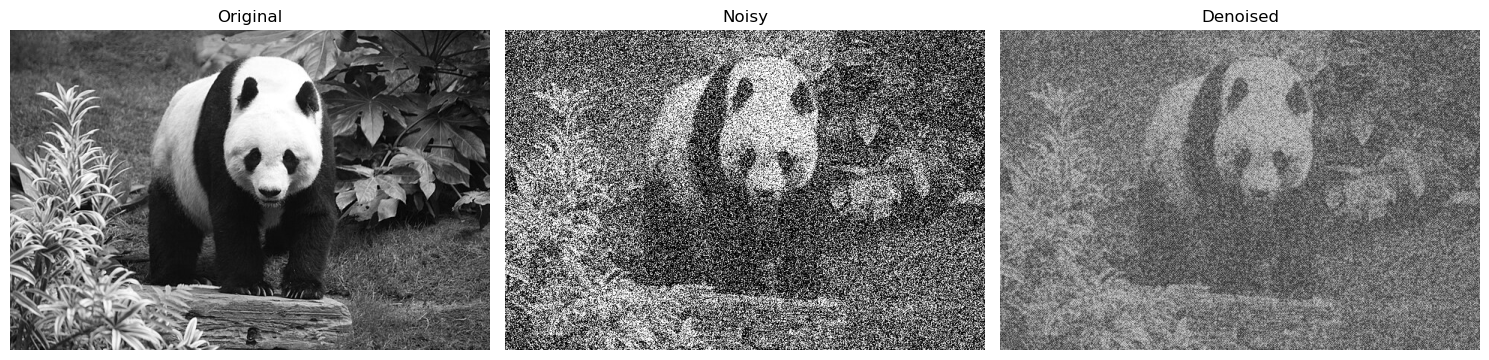

(array([[0.16470588, 0.16339869, 0.1869281 , ..., 0.11764706, 0.13464052,
         0.12810458],
        [0.16862745, 0.1751634 , 0.21437908, ..., 0.14771242, 0.1620915 ,
         0.09019608],
        [0.18823529, 0.19084967, 0.23006536, ..., 0.19607843, 0.19607843,
         0.08496732],
        ...,
        [0.29673203, 0.36601307, 0.25228758, ..., 0.21437908, 0.13202614,
         0.21437908],
        [0.22614379, 0.29934641, 0.23267974, ..., 0.29281046, 0.2379085 ,
         0.23398693],
        [0.14901961, 0.22091503, 0.18562092, ..., 0.16732026, 0.14379085,
         0.12810458]]),
 array([[0.40687886, 0.22154491, 0.91438809, ..., 0.        , 0.6895388 ,
         0.72737572],
        [0.13228513, 0.        , 0.57677213, ..., 0.71227542, 0.07527274,
         0.        ],
        [0.10796317, 0.        , 0.76945581, ..., 0.        , 0.44276694,
         0.        ],
        ...,
        [0.        , 1.        , 0.21668987, ..., 0.17078672, 0.        ,
         0.7371424 ],
        [0.1

In [25]:
# Example usage
process_and_display('img/panda.jpg', apply_noise=True, noise_type='gaussian', noise_var=.3, lambda_val=1, num_iters=100, eta=.2)